<a href="https://colab.research.google.com/github/jaswu51/GraphEmbeddings/blob/main/GraphEmbeddings_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node-level Embedding via: Graph Attention Network (GAT)

We use GAT from PyG package, because it allows the input of the edge attributes.

Firstly, we will get each node's embedding vector, then a readout function is implemented to aggregate the node vector into a graph summary, such as mean, max. 

In [ ]:
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [ ]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 1.9 MB 28.7 MB/s 
     |████████████████████████████████| 9.4 MB 50.7 MB/s 
     |████████████████████████████████| 4.5 MB 62.0 MB/s 
     |████████████████████████████████| 3.2 MB 56.9 MB/s 
     |████████████████████████████████| 873 kB 40.9 MB/s 
     |████████████████████████████████| 564 kB 30.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=59fa6186050aee007b6964913d3c7ef48ceddcc337ce5463cc7a33c4a57cbd16
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges

edge_index = torch.tensor([[0, 1, 1, 6,2, 7, 8, 2,3, 4, 1, 2,5, 9],
                           [1, 3, 2, 1,6, 1, 7, 2,5, 3, 1, 2,9, 3]], dtype=torch.long)

edge_attr =  torch.tensor([
                            [0, 1],
                            [1, 2],
                           [9, 8], 
                          [2, 1],
                           [7, 0], 
                          [2, 3],
                           [4, 0], 
                          [2, 5],
                           [6, 0], 
                          [2, 1],
                           [4, 0], 
                          [2, 5],
                           [6, 0], 
                          [2, 1]
                           ], dtype=torch.float)
x_features = torch.tensor([[-1,12,23,1,21], 
                           [-1,12,23,1,21], 
                           [-1,12,23,1,21], 
                           [-1,12,23,1,21], 
                           [-1,12,23,1,21], 
                           [-1,12,23,1,21], 
                           [-1,12,23,1,21], 
                           [-1,12,23,1,21], 
                  [12,3,12,4,0], 
                  [1,23,12,2,1]], dtype=torch.float)

graph_label= torch.tensor([[1],[0],[1],[0],[1],[0],[1],[0],[1],[1]], dtype=torch.float)
data = Data(x=x_features, edge_index=edge_index,edge_attr=edge_attr,y=graph_label)
data

Data(x=[10, 5], edge_index=[2, 14], edge_attr=[14, 2], y=[10, 1])

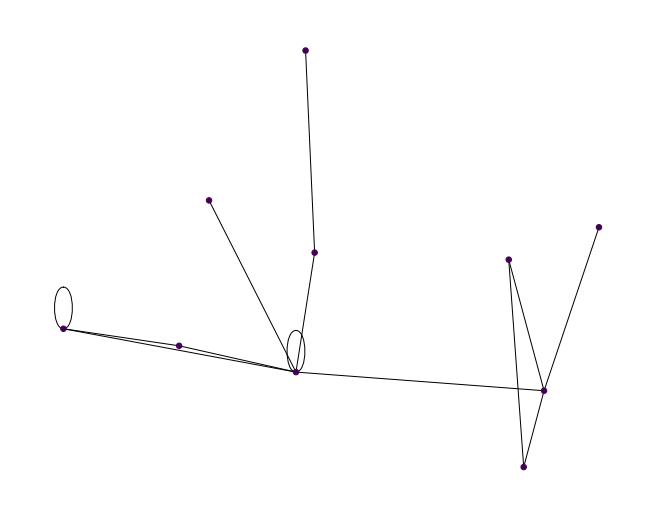

In [ ]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
    
g, y = convert_to_networkx(data)
plot_graph(g, y)

In [ ]:
a = torch.rand(data.num_nodes)
train_mask = a<0.6
val_mask= a>0.8
test_mask=~(train_mask + val_mask)

In [ ]:
data

Data(x=[10, 5], edge_index=[2, 14], edge_attr=[14, 2], y=[10, 1], train_mask=[10], test_mask=[10], val_mask=[10])

In [ ]:
data.train_mask=train_mask
data.test_mask=test_mask
data.val_mask=val_mask
val_mask

tensor([False, False, False,  True, False, False, False,  True, False, False])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, Batch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable

class GAT(nn.Module):
    r"""Graph Attention Network to extract the feature of physical network."""
    def __init__(self, input_dim, output_dim, embedding_dim, heads=1, edge_dim=None, dropout_prob=0.2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, embedding_dim, heads=heads, edge_dim=edge_dim)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.conv2 = GATConv(embedding_dim, embedding_dim, heads=heads, edge_dim=edge_dim)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.conv3 = GATConv(embedding_dim, output_dim, heads=heads, edge_dim=edge_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data['x'], data['edge_index'], data.get('edge_attr', None)
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = self.conv3(x, edge_index, edge_attr)
        return F.sigmoid(x) 

In [ ]:
num_features=data.num_features
num_classes=1
hidden_channels=3
heads=1
epochs=10
dropout_prob=0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(input_dim=num_features, embedding_dim=hidden_channels, output_dim=num_classes,edge_dim=2,dropout_prob=dropout_prob,heads=heads).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=7)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    # print("out")
    # print(out)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    # print("loss")
    # print(loss)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
      threhold = Variable(torch.Tensor([0.5]))  # threshold
      pred_binary = (pred[mask] > threhold).float() * 1
      accs.append(int((pred_binary == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [ ]:
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {tmp_test_acc:.4f}')

Epoch: 001, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 002, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 003, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 004, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 005, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 006, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 007, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 008, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 009, Train: 1.0000, Val: 1.0000, Test: 1.0000
Epoch: 010, Train: 1.0000, Val: 1.0000, Test: 1.0000
